In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# # Load the dataset
# df = pd.read_csv("../data/processed/text_preprocessed_scaled.csv")
# print(f"Dataset loaded with shape: {df.shape}")

# # Display the first few rows of the dataset
# df.head()

# Downloading and loading the preprocessed dataset
import gdown
import pandas as pd

#https://drive.google.com/file/d/1ATmJvIc9EsDkE8agxqbE27-gIWjwVb5i/view?usp=sharing

# Define Google Drive link for the dataset
gdrive_link = "https://drive.google.com/uc?export=download&id=1ATmJvIc9EsDkE8agxqbE27-gIWjwVb5i"  # Replace FILE_ID_TEXT_PREPROCESSED

# Define local path to save the dataset
local_path = "../data/processed/text_preprocessed_scaled.csv"

# Download the dataset
print("Downloading the dataset for Model Training...")
gdown.download(gdrive_link, local_path, quiet=False)

# Load the dataset
df = pd.read_csv(local_path)
print("Dataset loaded successfully.")



Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ATmJvIc9EsDkE8agxqbE27-gIWjwVb5i
From (redirected): https://drive.google.com/uc?export=download&id=1ATmJvIc9EsDkE8agxqbE27-gIWjwVb5i&confirm=t&uuid=2c63e0d3-83f7-4580-bc0c-88d5e0410359
To: e:\fake-news-detection\data\processed\text_preprocessed_scaled.csv
100%|██████████| 181M/181M [00:04<00:00, 45.0MB/s] 


Dataset loaded successfully.


In [60]:
from sklearn.preprocessing import StandardScaler

# Define numeric features
numeric_features = ['title_length', 'text_length', 'sentiment', 'readability']

# Re-apply standard scaling
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Save the updated DataFrame (if necessary)
df.to_csv("../data/processed/text_preprocessed_scaled.csv", index=False)

# Validate scaling again
scaling_issues = {}
for feature in numeric_features:
    mean = df[feature].mean()
    std = df[feature].std()
    if not (-0.1 <= mean <= 0.1 and 0.9 <= std <= 1.1):  # Slight tolerance for scaling
        scaling_issues[feature] = {'mean': mean, 'std': std}
if not scaling_issues:
    print("✅ Numeric features are now properly scaled!")
else:
    print(f"❌ Scaling issues persist in: {scaling_issues}")


✅ Numeric features are now properly scaled!


In [61]:
# Validation Script for Dataset
print(f"Dataset Shape: {df.shape}")

# Check if the target column 'label_encoded' exists and is binary
if 'label_encoded' in df.columns:
    unique_labels = df['label_encoded'].unique()
    print(f"Unique Values in 'label_encoded': {unique_labels}")
    if set(unique_labels) == {0, 1}:
        print("✅ 'label_encoded' is binary and correctly formatted.")
    else:
        print("❌ 'label_encoded' is not binary or contains unexpected values.")
else:
    print("❌ 'label_encoded' column is missing.")

# Check for the presence of necessary numeric features
numeric_features = ['title_length', 'text_length', 'sentiment', 'readability']
missing_features = [feature for feature in numeric_features if feature not in df.columns]
if missing_features:
    print(f"❌ Missing Numeric Features: {missing_features}")
else:
    print("✅ All numeric features are present.")

# Check if numeric columns are properly scaled (mean ~ 0, std ~ 1)
scaling_issues = {}
for feature in numeric_features:
    mean = df[feature].mean()
    std = df[feature].std()
    if not (-0.1 <= mean <= 0.1 and 0.9 <= std <= 1.1):  # Slight tolerance for scaling
        scaling_issues[feature] = {'mean': mean, 'std': std}
if scaling_issues:
    print(f"❌ Scaling issues found in: {scaling_issues}")
else:
    print("✅ Numeric features are properly scaled.")

# Summary check
if 'label_encoded' in df.columns and set(df['label_encoded'].unique()) == {0, 1} and not missing_features and not scaling_issues:
    print("✅ All validations passed!")
else:
    print("❌ Validation failed! Please address the issues listed above.")


Dataset Shape: (31794, 10)
Unique Values in 'label_encoded': [0 1]
✅ 'label_encoded' is binary and correctly formatted.
✅ All numeric features are present.
✅ Numeric features are properly scaled.
✅ All validations passed!


In [78]:
import joblib

# Load the processed features and labels
features = joblib.load('final_features.pkl')
labels = joblib.load('labels.pkl')

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (31794, 10004)
Labels shape: (31794,)


In [79]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape) #samples for training, features of each sample
print("Test set size:", X_test.shape) #no. of samples for testing with same no. of features
print("Training set size:", y_train.shape) #these are to ensure no. of labels = no. of samples in X_train & X_test
print("Test set size:", y_test.shape)

Training set size: (25435, 10004)
Test set size: (6359, 10004)
Training set size: (25435,)
Test set size: (6359,)


In [80]:
from imblearn.over_sampling import SMOTE
from scipy.sparse import vstack, csr_matrix
from collections import Counter

# Ensure training data is sparse
X_train_sparse = csr_matrix(X_train)

# Check original class distribution
print("Original class distribution:", Counter(y_train))

# Apply SMOTE in smaller batches
def smote_in_batches(X, y, batch_size=1000):
    smote = SMOTE(random_state=42)
    X_batches = []
    y_batches = []
    
    # Process in batches
    for i in range(0, X.shape[0], batch_size):
        batch_X = X[i:i+batch_size].toarray()  # Convert batch to dense
        batch_y = y[i:i+batch_size]
        X_smote, y_smote = smote.fit_resample(batch_X, batch_y)
        X_batches.append(csr_matrix(X_smote))  # Convert back to sparse
        y_batches.append(y_smote)
    
    # Combine all batches
    return vstack(X_batches), np.concatenate(y_batches)

# Apply chunk-wise SMOTE
X_train_smote, y_train_smote = smote_in_batches(X_train_sparse, y_train, batch_size=500)

# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_train_smote))


Original class distribution: Counter({np.int64(1): 17403, np.int64(0): 8032})
Class distribution after SMOTE: Counter({np.int64(0): 17403, np.int64(1): 17403})


In [65]:
# Scale numeric features to ensure they have similar ranges
from sklearn.preprocessing import StandardScaler

# Numeric features to scale
numeric_features = ['title_length', 'text_length', 'sentiment', 'readability']
scaler = StandardScaler()

# Scale numeric features
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print(df[numeric_features].head())


   title_length  text_length  sentiment  readability
0      0.516916     0.226032   0.301809     1.022791
1     -0.130742    -0.369363  -0.660008     0.497542
2      1.229340     0.647296  -0.741033     0.548434
3      0.452151     0.154824  -0.859950     0.452934
4     -0.065976    -0.101286  -0.734159     0.767706


# using imbalanced training set

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
print("Training Logistic Regression model...")
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.2f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))


Training Logistic Regression model...
Baseline Model Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2014
           1       0.99      1.00      0.99      4345

    accuracy                           0.99      6359
   macro avg       0.99      0.99      0.99      6359
weighted avg       0.99      0.99      0.99      6359



# using balanced data

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression
baseline_model = LogisticRegression(max_iter= 1000, random_state= 42)

# Train the model
print("Training Logistic Regression model...")
baseline_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.2f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))


Training Logistic Regression model...
Baseline Model Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2014
           1       0.99      0.99      0.99      4345

    accuracy                           0.99      6359
   macro avg       0.99      0.99      0.99      6359
weighted avg       0.99      0.99      0.99      6359



In [68]:
# Save the logistic regression model after training with SMOTE data
joblib.dump(baseline_model, 'logistic_model_balanced.pkl')
# Save the scaler used for numeric features
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

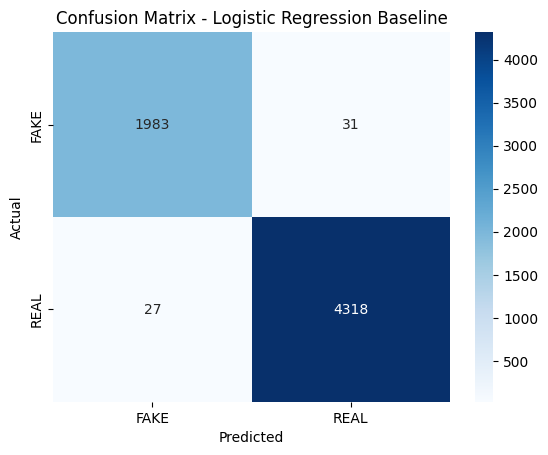

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


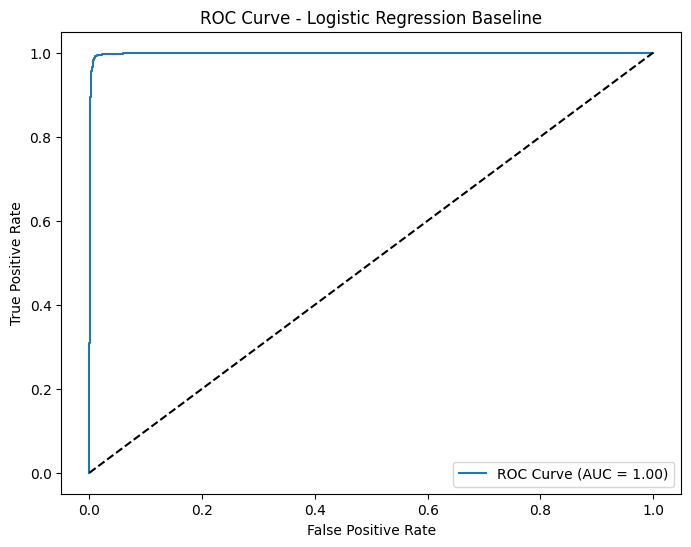

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve
y_probs_baseline = baseline_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs_baseline)

fpr, tpr, thresholds = roc_curve(y_test, y_probs_baseline)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression Baseline")
plt.legend()
plt.show()


Training Random Forest model...
Random Forest Model Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2014
           1       0.99      0.99      0.99      4345

    accuracy                           0.99      6359
   macro avg       0.99      0.99      0.99      6359
weighted avg       0.99      0.99      0.99      6359



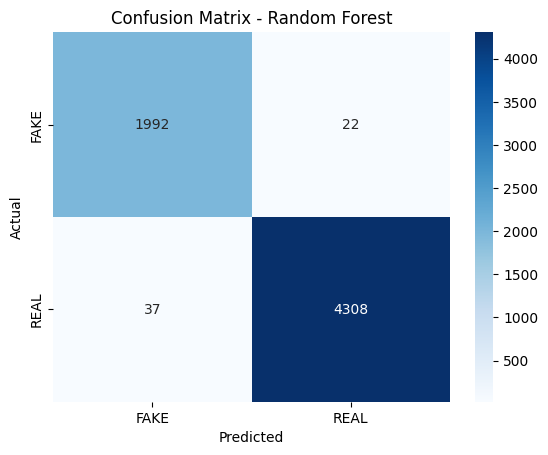

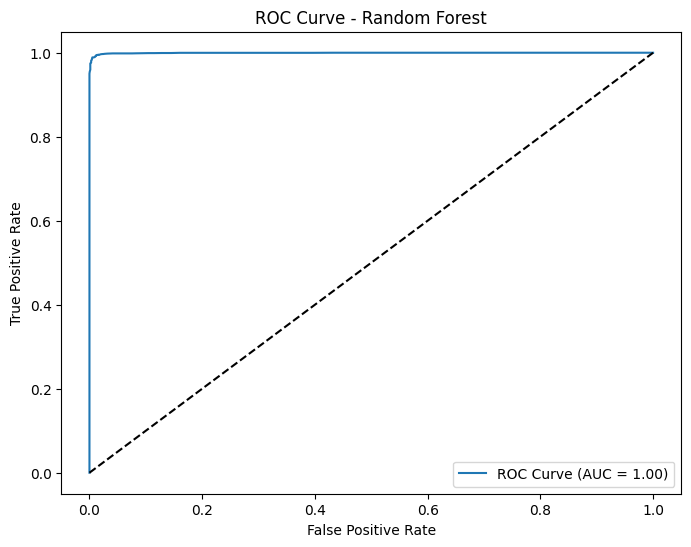

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)

# Train the Random Forest model using SMOTE-balanced data
print("Training Random Forest model...")
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy: {rf_accuracy:.2f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ROC Curve
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [72]:
# Save the Random Forest model trained with balanced data
joblib.dump(rf_model, 'rf_model_balanced.pkl')


['rf_model_balanced.pkl']

In [73]:
print(type(features))


<class 'scipy.sparse._csr.csr_matrix'>



Top 10 Most Important Features:
         Feature  Importance
8848  revelation    0.089151
7266   immigrant    0.061805
0             10    0.030563
8951      salman    0.024260
6751     factory    0.020053
4626  trumpputin    0.012748
1            100    0.011135
9539     thought    0.011112
7690     limited    0.011083
4787        view    0.010984


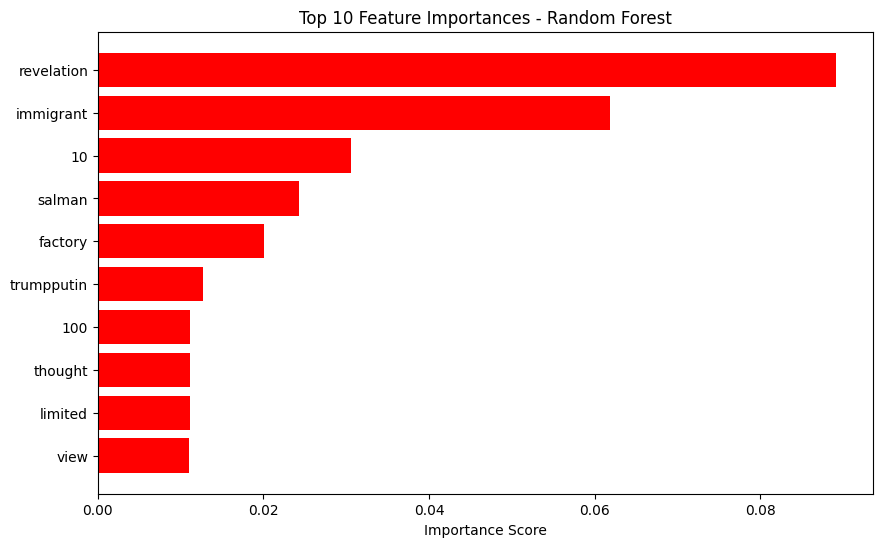

In [74]:
import numpy as np

# Load the NumPy file
features = np.load('features_names_variable.npy')
# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Combine feature names with their importance scores
feature_names = features.tolist()
feature_importances = feature_importances[:len(feature_names)]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 features
top_features = feature_importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='red')
plt.gca().invert_yaxis()  # Show most important feature at the top
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()


In [75]:
!pip install textstat


In [89]:
import joblib
import numpy as np
from scipy.sparse import hstack
from textstat import flesch_reading_ease
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob


# Load trained models
logistic_model = joblib.load('logistic_model_balanced.pkl')  # Assuming this is the saved Logistic Regression model
rf_model = joblib.load('rf_model_balanced.pkl')  # Assuming this is the saved Random Forest model

# Load vectorizers and scaler
title_vectorizer = joblib.load('title_vectorizer.pkl')
text_vectorizer = joblib.load('text_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')

# Define a function for predictions
def predict_news_class(title, text, model):
    """
    Predict whether a news article is REAL or FAKE using the trained model.
    
    Parameters:
    - title: str, the title of the news article
    - text: str, the text of the news article
    - model: trained model (Logistic Regression or Random Forest)
    
    Returns:
    - prediction: str ("REAL" or "FAKE")
    - probabilities: dict with probabilities for both classes
    """
    # Preprocess the numeric features
    title_length = len(title)
    text_length = len(text)
    sentiment = TextBlob(text).sentiment.polarity
    readability = flesch_reading_ease(text)

    numeric_features = np.array([[title_length, text_length, sentiment, readability]])
    scaled_numeric_features = scaler.transform(numeric_features)

    # Vectorize title and text
    title_vector = title_vectorizer.transform([title])
    text_vector = text_vectorizer.transform([text])

    # Combine all features
    final_features = hstack([scaled_numeric_features, title_vector, text_vector])

    # Make predictions
    pred = model.predict(final_features)[0]
    proba = model.predict_proba(final_features)[0]

    # Format the output
    prediction = "REAL" if pred == 1 else "FAKE"
    probabilities = {"FAKE": proba[0], "REAL": proba[1]}

    return prediction, probabilities


# Test examples
# 1. Example from the dataset
dataset_title = "Democratic lawmakers report Thanksgiving bomb threats against their homes"
dataset_text = """
WEST PALM BEACH, Fla. — At least five Democratic members of Congress from Connecticut were targeted by bomb threats on their homes Thursday, 
the lawmakers or their offices said. Sen. Chris Murphy and Reps. Jim Himes, Joe Courtney, John Larson and Jahana Hayes all reported being the subject of such threats. 
Police who responded said they found no evidence of explosives on the lawmakers' properties.
"""
print("Testing with a dataset example:")
pred, proba = predict_news_class(dataset_title, dataset_text, rf_model)
print(f"Prediction: {pred}")
print(f"Probabilities: {proba}")

# 2. Unseen real-world example
real_world_title = "NASA announces discovery of Earth-like planet orbiting distant star"
real_world_text = """
In a groundbreaking announcement, NASA has revealed the discovery of an Earth-like exoplanet located in the habitable zone of a distant star. 
Astronomers believe this planet could harbor conditions suitable for life, making it one of the most promising candidates for extraterrestrial exploration to date.
"""
print("\nTesting with unseen real-world data:")
pred, proba = predict_news_class(real_world_title, real_world_text, rf_model)
print(f"Prediction: {pred}")
print(f"Probabilities: {proba}")


Testing with a dataset example:
Prediction: REAL
Probabilities: {'FAKE': np.float64(0.41), 'REAL': np.float64(0.59)}

Testing with unseen real-world data:
Prediction: FAKE
Probabilities: {'FAKE': np.float64(0.52), 'REAL': np.float64(0.48)}


e:\fake-news-detection\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
e:\fake-news-detection\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
new_title = "Iran reportedly makes new push for uranium concessions in nuclear talks"
new_text = "Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made in favor of the deal by the Obama administration. The Times reports that if the uranium had gone to Russia, it would have been converted into fuel rods, which are difficult to use in nuclear weapons. It is not clear what would happen to the uranium if it remained in Iran. The Associated Press reported Sunday that Iran's position had shifted from from demanding that it be allowed to keep nearly 10,000 centrifuges enriching uranium, to agreeing to keep 6,000. Western officials involved in the talks told the Associated Press that Tehran may be ready to accept an even lower number.The United States and its allies want a deal that extends the time Iran would need to make a nuclear weapon from the present two months to three months to at least a year. However, The Times reported Sunday that a paper published by Olli Heinonen, former head of inspections for the U.N.'s nuclear watchdog, estimated that Iran could still develop a nuclear weapon in seven or eight months with around 6,500 centrifuges.Tehran says it wants to enrich uranium only for energy, science, industry and medicine. But many countries fear Iran could use the technology to make weapons-grade uranium.Officials told the Associated Press that another main dispute involved the length of an agreement. Iran, they said, wants a total lifting of all caps on its activities after 10 years, while the U.S. and the five other nations at the talks â€” Russia, China, Britain, France and Germany â€” insist on progressive removal after a decade.A senior U.S. official characterized the issue as lack of agreement on what happens in years 11 to 15. The official spoke on condition of anonymity in line with State Department rules on briefing about the closed-door talks.Limits on Iran's research and development of centrifuges also were unresolved, the Western officials said.Tehran has created a prototype centrifuge that it says enriches uranium 16 times faster than its present mainstay model. The U.S. and its partners want to constrain research that would increase greatly the speed of making enough weapons-grade uranium for a bomb, once limits on Iran's programs are lifted.One official said Russia opposed the U.S. position that any U.N. penalties lifted in the course of a deal should be reimposed quickly if Tehran reneged on any commitments.Both Western officials said Iran was resisting attempts to make inspections and other ways of verification as intrusive as possible.There was tentative agreement on turning a nearly-finished reactor into a model that gives off less plutonium waste than originally envisaged. Plutonium, like enriched uranium, is a path to nuclear weapons.Iran and the U.S. were discussing letting Iran run centrifuges at an underground bunker that has been used to enrich uranium. The machines would produce isotopes for peaceful applications, the officials said. With the Tuesday deadline approaching and problems remaining, U.S. Secretary of State John Kerry canceled plans Sunday to return to the United States for an event honoring the late U.S. Sen. Edward Kennedy. French Foreign Minister Laurent Fabius and Frank-Walter Steinmeier, his German counterpart, scratched planned trips to Kazakhstan.Kerry has been in discussions with Iranian Foreign Minister Mohammad Javad Zarif since Thursday.The Associated Press contributed to this report.Click for more from The New York Times."

In [ ]:
#fake news from dataset
new_title = "mayoral candidate diehard democrat city may prove 2016 trump win beginning end democrat"
new_text = "john persinger win mayoral race erie pa next month might greatest local political upset america century republican candidate elected mayor since 1961 jfk presidenttall witty energetic razorsharp persinger guy expect settle town like erie kind person leaf move blazing success elsewhere never returnspersinger grandfather john demarco son italian immigrant supposed take family grocery store instead went medical school ended delivering 12000 erie babiesbefore born persinger parent moved suburb outside new york ommunity center mosque synagogue knock door democratic republican mayoral candidate decade especially africanamerican hispanic communitiesand listens trait gone unnoticed black community year vote taken granted democrat ignored republicansjust ask steve mclallen got visit persinger earlier year hey want let know appreciate willingness come listen concern mclallen told persinger shook hand gop candidate made impression impact traveling neighborhood work actually asking u need longtime democrat mclallen said voting persingerjim baer meanwhile looking new blood mayor office welder fralo democrat vote clinton trump tired old politics look tried old way nothing democrat running city managing decline time place someone young different idea willingness listen charge saidwhile neither candidate invested polling keep detailed data campaign voter outreach know race close entire story nyp"

In [ ]:
new_title = "Democratic lawmakers report Thanksgiving bomb threats against their homes"
new_text = "WEST PALM BEACH, Fla. — At least five Democratic members of Congress from Connecticut were targeted by bomb threats on their homes Thursday, the lawmakers or their offices said. Sen. Chris Murphy and Reps. Jim Himes, Joe Courtney, John Larson and Jahana Hayes all reported being the subject of such threats. Police who responded said they found no evidence of explosives on the lawmakers' properties. There was no immediate word whether Rep. Rosa DeLauro, the fifth Democratic House member from the state, and Connecticut's other Democratic senator received threats. The bomb threats against Democrats happened a day after a number of President-elect Donald Trump 's most prominent Cabinet picks and appointees reported that they had received such threats, as well as swatting attacks in which perpetrators initiate an emergency law enforcement response against a victim under false pretenses. Murphy's office said his Hartford home was the target of a bomb threat, which appears to be part of a coordinated effort involving multiple members of Congress and public figures. Hartford Police and U.S. Capitol Police determined there was no threat. Hayes said the Wolcott Police Department informed her Thursday morning that it had received a threatening email stating a pipe bomb had been placed in the mailbox at my home. State police, U.S. Capitol Police, and the House sergeant at arms were notified, Wolcott and state police responded and no bomb or explosive materials were discovered. Courtney's Vernon home received a bomb threat while his wife and children were there, his office said."